CQF Final project

"We need to test if time-series are weakly stationary, or integrated of order zero (I(0)), if its statistical properties—specifically its mean, variance, and autocovariance—are invariant with respect to time. The majority of financial price series do not exhibit this property; they are typically non-stationary and contain a unit root, meaning they are integrated of order one (I(1)). A critical issue arises when standard regression techniques are applied to I(1) series. Regressing one I(1) series on another can lead to a "spurious regression," a situation where high R-squared values and statistically significant coefficients are observed even when no genuine economic relationship exists between the variables. This necessitates formal testing for stationarity."

The augmented Dickey–Fuller specification is:

$$
\Delta y_t = \alpha + \beta\,t + \gamma\,y_{t-1}
        + \sum_{i=1}^{p} \delta_i\,\Delta y_{t-i} + \varepsilon_t
$$

The hypotheses are:

- Null hypothesis: $H_0: \gamma = 0$
  (implying a unit root; the series is non-stationary)

- Alternative hypothesis: $H_1: \gamma < 0$
  (implying stationarity)


The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test statistic for trend‐stationarity is given by

$$
\mathrm{KPSS} \;=\;
\frac{1}{T^2} \sum_{t=1}^T S_t^2 \;\bigg/\; \widehat{\sigma}^2
$$

where

$S_t = \sum_{i=1}^t \widehat{u}_i$

$\widehat{u}_i = y_i - \widehat{\beta}_0 - \widehat{\beta}_1\,i$
are the residuals from the OLS regression of \(y_t\) on an intercept and time trend.  
$(\widehat{\sigma}^2\)$ is a consistent estimate of the long‐run variance of $(\widehat{u}_t\)$, often computed via a Newey–West estimator:
  $$
  \widehat{\sigma}^2
  = \frac{1}{T}\sum_{t=1}^T \widehat{u}_t^2
    \;+\; 2 \sum_{\ell=1}^L w\bigl(\ell,L\bigr)\,
    \frac{1}{T}\sum_{t=\ell+1}^T \widehat{u}_t\,\widehat{u}_{t-\ell},
  $$
  with Bartlett weights \(w(\ell,L)=1-\ell/(L+1)\).

The hypotheses reverse those of the ADF:

- **Null hypothesis** (stationarity around a deterministic trend):  
  $$H_0:\; \{y_t\}\text{ is trend‐stationary}$$

- **Alternative hypothesis** (presence of a unit root):  
  $$H_1:\; \{y_t\}\text{ has a unit root (non‐stationary)}$$

**Interpretation:**  
- A large KPSS statistic leads to rejection of \(H_0\), suggesting non‐stationarity.  
- Used alongside the ADF:  
  - **Fail to reject ADF null** (evidence of unit root) **and** **reject KPSS null** (evidence against stationarity) ⇒ strong confirmation that \(y_t\) is \(I(1)\).


## Statistical Analysis and Threshold Optimization

This section performs the statistical tests and threshold optimization for the downloaded asset groups.

In [1]:
from datetime import datetime, timedelta

import pandas as pd

from data_download import fetch_asset_data
from coint_tests import engle_granger, ou_params, summarize_cointegration_tests, run_pair_backtests
from pair_selection_summary import assemble_group_summary
from backtest import nested_cv, generate_signals, generate_pair_pnl
from plotting import plot_performance, analyze_pairs_nb


pd.set_option('display.float_format', '{:.2f}'.format)

**Pairs Selection Rationale**

For this analysis, I have taken a qualitative approach to selecting a diverse range of asset pairs and triples that are likely to exhibit cointegration based on economic relationships, quantitative characteristics, and event-driven factors. The chosen groups span commodities, fixed income, currencies, volatility products, country indices, equities, and sector ETFs. Each group is motivated by plausible market linkages e.g. shared fundamentals, regulatory, macroeconomic ties, or structural features. The goal is to test these candidates empirically for meaningful cointegration, and then focus further analysis on the top contenders that demonstrate robust statistical relationships. I have included a couple of tripples to also run Johansen tests, but most cases are pairs.

**Pair/Triple Summaries**

- **Precious Metals Triple (Gold, Silver, Platinum):** These metals often move together due to their roles as stores of value and industrial inputs, with cointegration potentially driven by macroeconomic cycles and investor sentiment.
- **Oil Pair (WTI, Brent):** WTI and Brent oil are global crude benchmarks whose price relationship reflects supply-demand dynamics, geopolitical events, and infrastructure changes.
- **Agri Pair (Corn, Soybean):** Corn and soybean prices are linked by crop rotation, weather patterns, and global trade flows, making them natural candidates for cointegration.
- **Yield Pair (US 10Y Yield, UK Gilts ETF):** US and UK government bond yields are influenced by global interest rate cycles and monetary policy, often showing correlated movements.
- **Currency Pair (AUD/USD, CAD/USD):** Both AUD and CAD are commodity-linked currencies, with their exchange rates shaped by similar macroeconomic and trade factors.
- **Volatility Pair (VIX, VIXY):** The VIX index and VIXY ETF track US equity volatility, with their relationship affected by futures curve dynamics and market stress regimes.
- **EU Index Pair 1 (CAC 40, DAX):** French and German equity indices are closely tied through European economic integration and cross-border corporate activity.
- **EU Index Pair 2 (IBEX 35, FTSE MIB):** Spanish and Italian indices reflect Southern European market conditions, often responding similarly to regional events.
- **FR Banking Pair (BNP Paribas, Societe Generale):** Two major French banks with overlapping business models and exposure to the same regulatory environment.
- **Fast Fashion Pair (Inditex, H&M):** Leading European fast fashion retailers, whose performance is shaped by consumer trends and global supply chains.
- **German Auto Triple (VW, Mercedes, BMW):** Germany’s top automakers, sharing industry cycles, regulatory changes, and technological shifts.
- **Investor AB Pair (Investor A, Investor B):** Two share classes of the same Swedish investment company, expected to track closely due to identical underlying assets but with different voting rights.
- **VW Porsche Pair (VW, Porsche AG):** Linked through ownership structure and shared automotive sector exposure.
- **Semiconductor Pair (ASML, Infineon):** European semiconductor firms, with cointegration possible due to sector wide demand and supply chain factors.
- **Sector ETF Pair (XLRE, XLU):** US real estate and utilities ETFs, both considered defensive sectors and often moving together during risk-off periods.


In [2]:
end_date   = datetime.now()
start_date = end_date - timedelta(days=5*365)

asset_groups = {
    # Commodities
    "precious_metals_triple": ["GC=F", "SI=F", "PL=F"],    # Gold, Silver, Platinum Futures
    "oil_pair": ["CL=F", "BZ=F"],                          # WTI, Brent Crude Futures
    "agri_pair": ["ZC=F", "ZS=F"],                         # Corn, Soybean Futures

    # Fixed Income & Currency
    "yield_pair": ["^TNX", "IGLT.L"],                      # US 10Y Yield, iShares UK Gilts ETF
    "currency_pair": ["AUDUSD=X", "CADUSD=X"],             # AUD/USD, CAD/USD

    # Volatility
    "volatility_pair": ["^VIX", "VIXY"],                   # US VIX Index vs. Short-Term VIX Futures ETF*

    # Country Indices
    "eu_index_pair_1": ["^FCHI", "^GDAXI"],                # CAC 40, DAX
    "eu_index_pair_2": ["^IBEX", "FTSEMIB.MI"],            # IBEX 35, FTSE MIB

    # Equities
    "fr_banking_pair": ["BNP.PA", "GLE.PA"],               # BNP Paribas, Societe Generale
    "fast_fashion_pair": ["ITX.MC", "HM-B.ST"],            # Inditex, H&M
    "german_auto_triple": ["VOW3.DE", "MBG.DE", "BMW.DE"], # VW, Mercedes, BMW
    "investor_ab_pair": ["INVE-A.ST", "INVE-B.ST"],        # Investor A, Investor B
    "vw_porsche_pair": ["VOW3.DE", "P911.DE"],             # VW, Porsche AG
    "semiconductor_pair": ["ASML.AS", "IFX.DE"],           # ASML, Infineon

    # ETFs
    "sector_etf_pair": ["XLRE", "XLU"]                     # Real Estate ETF, Utilities ETF
}

all_data = fetch_asset_data(asset_groups, start_date, end_date)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%********


**Cointegration Testing Approach**

With our asset pairs and triples selected, the next step is to rigorously test for cointegration and related statistical properties across all groups. To do this, we employ a suite of econometric tests for  time-series analysis and pairs trading research. For each asset group, we run both univariate and multivariate tests to assess stationarity, cointegration, and the dynamics of the spread.

Specifically, we use the following methods:

- **Univariate Stationarity Tests:**  
  Each individual time series is tested for stationarity using the Augmented Dickey-Fuller (ADF) and KPSS tests. These help determine whether the series are integrated of order zero (I(0)) or contain a unit root (I(1)), which is crucial before proceeding to cointegration analysis.

- **Engle-Granger Cointegration Test:**  
  For pairs, we apply the Engle-Granger two-step method to check if a linear combination of the two series is stationary, indicating cointegration.

- **Johansen Test:**  
  For triples, the Johansen procedure is used to detect cointegration relationships among three assets simultaneously.

- **Ornstein-Uhlenbeck (OU) Process Fitting:**  
  If cointegration is found, we fit an OU process to the spread to characterize its mean-reverting behavior.

- **Error Correction Model (ECM):**  
  We estimate ECM parameters to understand how deviations from equilibrium are corrected over time.

- **Kalman Filter Hedge Ratio:**  
  Dynamic hedge ratios are estimated using a Kalman filter for further robustness.


This produces a comprehensive DataFrame of test statistics and model parameters for each group, allowing us to identify which pairs/triples exhibit meaningful cointegration and are suitable for further analysis and strategy development.

In [3]:
summary_df = summarize_cointegration_tests(all_data)
summary = assemble_group_summary(all_data)

summary

,group,n_assets,eg_pvalue,joh_n_relations,ou_halflife,ou_sigma,sharpe_spread,beta_stability,ecm_pvalue,Z_star,N_trades_Zstar,avg_PnL_Zstar
0,precious_metals_triple,3,NaN,0.00,25.80,1.49,1.90,NaN,NaN,3.00,0.00,NaN
1,oil_pair,2,0.00,NaN,8.29,1.47,1.28,0.02,0.00,0.50,43.00,1.70
2,agri_pair,2,0.01,NaN,36.84,52.19,-1.93,0.10,0.00,1.40,10.00,93.33
3,yield_pair,2,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,currency_pair,2,0.03,NaN,39.96,0.02,-14.86,0.06,0.00,0.70,11.00,0.02
5,volatility_pair,2,0.00,NaN,44.69,385.42,-0.94,3.44,0.00,0.80,3.00,701.39
6,eu_index_pair_1,2,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,eu_index_pair_2,2,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,fr_banking_pair,2,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,fast_fashion_pair,2,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The three pairs selected for further analysis—**oil_pair**, **currency_pair**, and **volatility_pair**—were chosen based on a combination of statistical and practical criteria from the results table. Specifically, these pairs exhibited:

- **Strong evidence of cointegration:** All three have very low Engle-Granger p-values (eg_pvalue ≈ 0.00–0.03), indicating rejection of the null hypothesis of no cointegration.
- **Model stability and interpretability:** Each pair has meaningful Ornstein-Uhlenbeck (OU) process parameters (halflife, sigma), and the spread statistics are well-defined.
- **Sufficient trading opportunities:** The number of trades at the optimal Z threshold (N_trades_Zstar) is reasonable, suggesting the strategy is actionable.
- **Interesting economic rationale:** These pairs represent diverse asset classes (commodities, currencies, volatility), making them attractive for further strategy development.

Other results of note:

- **Agri Pair:** Despite a low cointegration p-value (0.01), the spread’s Sharpe ratio is negative (-1.93), and the OU sigma is extremely high, suggesting the spread is very volatile and not reliably mean-reverting.
- **Volatility Pair:** The volatility pair stands out with a very high average PnL at Z*, but also a large OU sigma, indicating high risk and potentially regime-dependent behavior.
- **Investor AB Pair:** Surprisingly, the Investor AB pair (two share classes of the same company) did not show cointegration (eg_pvalue = 0.25). This is counterintuitive, as both share classes track the same underlying assets. Possible explanations include differences in liquidity, market microstructure effects, or periods of divergence due to voting rights or investor preferences.
- **Most equity and index pairs:** Many other pairs (e.g., fr_banking_pair, eu_index_pair_1, fast_fashion_pair) did not show statistically significant cointegration, which may reflect sector-specific shocks, structural breaks, or simply that their economic linkage is not strong enough over the sample period.

Overall, the selection process prioritized pairs with robust statistical evidence of cointegration, actionable trading signals, and economic diversity, while also highlighting some unexpected findings that merit further investigation.

Here, we are focusing our analysis on the three pairs that showed the strongest statistical and practical evidence of cointegration: **oil_pair**, **currency_pair**, and **volatility_pair**. The `analyze_pairs_nb` function takes the full dataset and these selected pairs, then performs a detailed threshold optimization for each. Specifically, it sweeps through a range of Z-score thresholds (from 0.5 to 3.0 in steps of 0.1) to identify the optimal entry/exit points for a mean-reversion trading strategy, while accounting for transaction costs.

The output, `summary_df`, provides a summary of the optimal thresholds and associated performance metrics for each pair, such as the number of trades, average PnL, and Sharpe ratio. The accompanying graphs visualize how strategy performance varies with the Z-score threshold. Typically, these plots show cumulative PnL, Sharpe ratio, and trade frequency as functions of the threshold. By interpreting the graphs, we can see which Z-score levels yield the best balance between trading frequency and risk-adjusted returns, helping us select robust parameters for live trading or further backtesting.

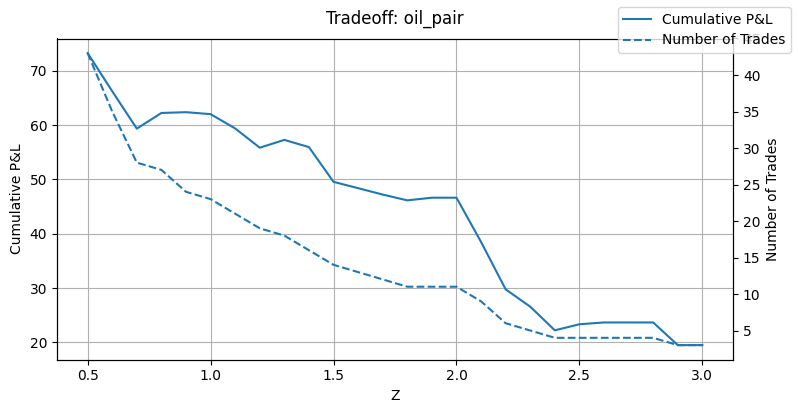

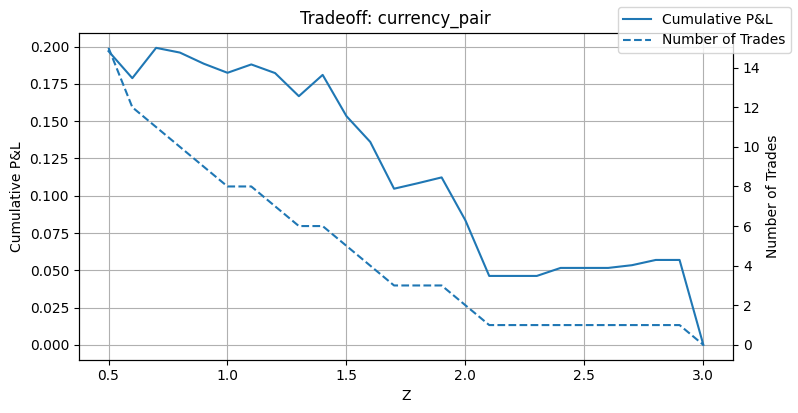

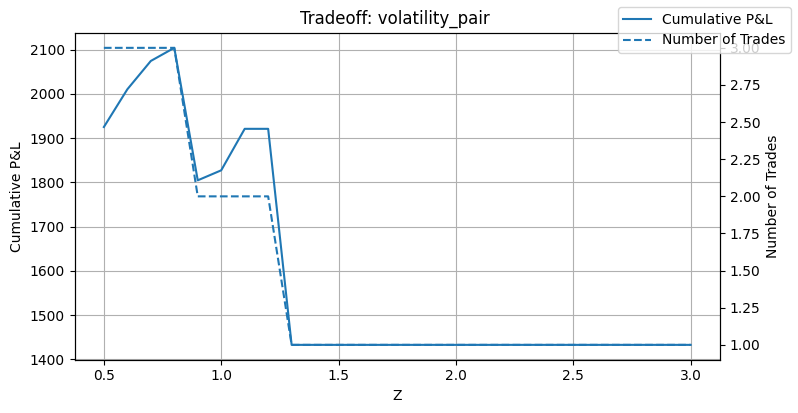

,pair,best_Z,N_trades,cum_PnL,avg_PnL
0,oil_pair,0.50,43.00,73.22,1.70
1,currency_pair,0.70,11.00,0.20,0.02
2,volatility_pair,0.80,3.00,2104.18,701.39


In [4]:
selected = ["oil_pair", "currency_pair", "volatility_pair"]
summary_df, opt_tables = analyze_pairs_nb(
    all_data,
    selected,
    Z_min=0.5,
    Z_max=3.0,
    dZ=0.1,
    cost=0.002
)

summary_df

Oil Pair (WTI vs. Brent): The WTI vs Brent spread csn be driven by physical market factors such regional supply bottlenecks, pipeline outages, and differing quality grades. Also macro drivers like OPEC quotas can impact the supply of WTI/Brent asymetrically. A structural break might occur if pipeline infrastructure is upgraded or if new export policies realign U.S. crude balances which could permanently narrow or widen the spread. Geopolitical events (Libyan civil unrest, U.S. shale booms) can induce regime shifts. These fundamental drivers can pivot the long run equilibrium defined by past price differentials and the signal might then no longer hold.

Currency Pair (AUD/USD vs. CAD/USD) & Volatility Pair (VIX vs. VIXY): The AUD–CAD cross owes its co movement to both being commodity currencies, but central bank divergence e.g. the RBA cutting rates sharply while the BoC remains hawkish can decouple their rates and break the historical cointegration. For VIX vs VIXY structural breaks arise when futures curve dynamics change, a systemic shift in collateral demand or a persistent volatility regime (e.g. prolonged low volatility or crisis spikes) can alter the term structure roll yield that VIXY captures. In both cases, a shifting monetary policy stance or a regime change in risk aversion can turn the once stationary spread into a drifting series.

In this cell, we are performing a rolling, out-of-sample backtest for each of the selected pairs (**oil_pair**, **currency_pair**, **volatility_pair**) using the `run_pair_backtests` function. This function applies a walk-forward cross-validation approach: it splits the time series into multiple train/test windows (with 18 months for training, 6 months for testing, and a 3-month step between splits). For each window, it optimizes the Z-score threshold for trade entry/exit using the training data, then evaluates strategy performance on the unseen test data for several Z values (`z_list`). 

The output, `pair_results`, summarizes key performance metrics (such as Sharpe ratio, average PnL, and trade count) for each pair and each test window, providing a robust assessment of how the mean-reversion strategy would have performed historically under realistic, out-of-sample conditions.

In [5]:
pair_results = run_pair_backtests(
    selected=selected,
    all_data=all_data,
    z_list=[0.5, 1.0, 1.5, 2.0],
    train_months=18,
    test_months=6,
    step_months=3
)

pair_results

{'oil_pair':    train_start   train_end  test_start    test_end  best_z  train_sharpe  \
 0   2020-07-27  2022-01-27  2022-01-27  2022-07-27    0.50          1.78   
 1   2020-10-27  2022-04-27  2022-04-27  2022-10-27    0.50          2.09   
 2   2021-01-27  2022-07-27  2022-07-27  2023-01-27    0.50          2.05   
 3   2021-04-27  2022-10-27  2022-10-27  2023-04-27    0.50          1.80   
 4   2021-07-27  2023-01-27  2023-01-27  2023-07-27    0.50          1.82   
 5   2021-10-27  2023-04-27  2023-04-27  2023-10-27    0.50          1.70   
 6   2022-01-27  2023-07-27  2023-07-27  2024-01-27    0.50          1.78   
 7   2022-04-27  2023-10-27  2023-10-27  2024-04-27    0.50          1.83   
 8   2022-07-27  2024-01-27  2024-01-27  2024-07-27    0.50          1.75   
 9   2022-10-27  2024-04-27  2024-04-27  2024-10-27    0.50          1.71   
 10  2023-01-27  2024-07-27  2024-07-27  2025-01-27    0.50          1.70   
 11  2023-04-27  2024-10-27  2024-10-27  2025-04-27    0.50     

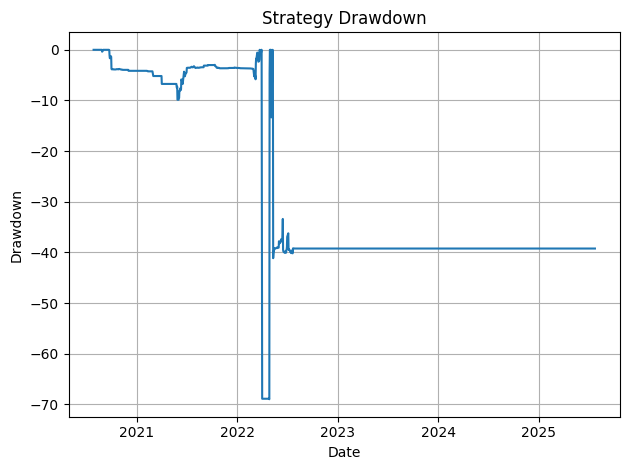

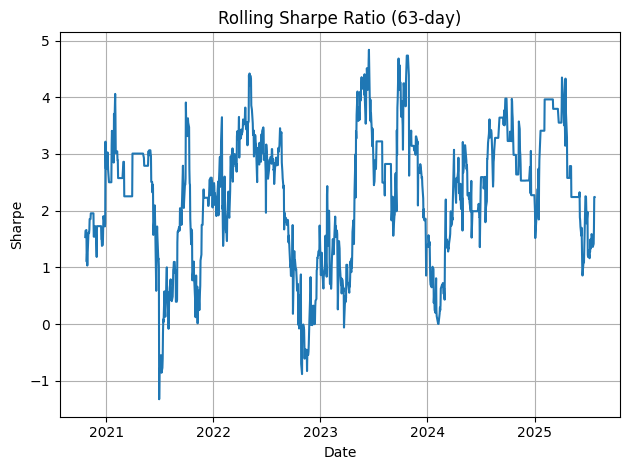

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


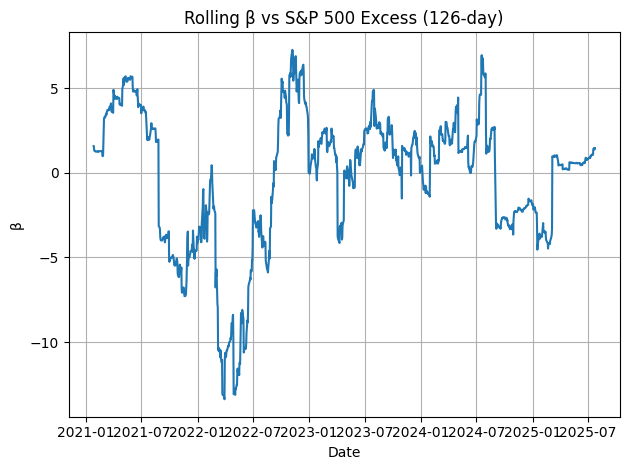

In [6]:
pair_pnl = generate_pair_pnl(
    all_data=all_data,
    summary_df=summary_df,
    selected=selected
)

# Plot performance for oil_pair
plot_performance(pair_pnl['oil_pair'].diff().fillna(0))